In [179]:
import re
import os

import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import norm
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [180]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 

In [181]:
accepted = pd.read_csv('accepted.csv')
rejected = pd.read_csv('rejected.csv')

## EDA

Data Dictionary: https://www.kaggle.com/datasets/jonchan2003/lending-club-data-dictionary

In [182]:
print(accepted.shape)
print(rejected.shape)

(2260701, 151)
(27648741, 9)


In [183]:
accepted.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

In [184]:
rejected.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


Looking at the datasets, we only need accepted loans to predict whether a loan is going to be default or not.

## Columns with Over 10% Null Values

In [185]:
print(accepted.isna().sum().sum())

108486249


In [186]:
percent_missing_a = accepted.isnull().sum() * 100 / len(accepted)
missing_values_a = pd.DataFrame({'column_name': accepted.columns,
                                 'percent_missing': percent_missing_a})

In [187]:
missing_values_a.sort_values(by=['percent_missing'], ascending=False)

,column_name,percent_missing
member_id,member_id,100.000000
orig_projected_additional_accrued_interest,orig_projected_additional_accrued_interest,99.617331
hardship_end_date,hardship_end_date,99.517097
hardship_start_date,hardship_start_date,99.517097
hardship_type,hardship_type,99.517097
hardship_reason,hardship_reason,99.517097
hardship_status,hardship_status,99.517097
deferral_term,deferral_term,99.517097
hardship_last_payment_amount,hardship_last_payment_amount,99.517097
hardship_payoff_balance_amount,hardship_payoff_balance_amount,99.517097


In [188]:
nan_percentage_a = accepted.isna().mean() * 100
columns_to_drop_a = nan_percentage_a[nan_percentage_a > 10].index.tolist()
accepted_cleaner = accepted.drop(columns=columns_to_drop_a)

In [189]:
accepted_cleaner.shape

(2260701, 92)

In [190]:
print(accepted_cleaner.isna().sum().sum())

2734063


## Duplicates

In [191]:
accepted_cleaner.duplicated().sum()

0

We have no duplicated rows!!

## Redundant Columns / Bad Data 

In [192]:
accepted_cleaner.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,Major purchase,174xx,PA,25.37

### Grade vs Sub Grade

In [193]:
accepted_cleaner['grade'].value_counts()

B    663557
C    650053
A    433027
D    324424
E    135639
F     41800
G     12168
Name: grade, dtype: int64

In [194]:
accepted_cleaner['sub_grade'].value_counts().sort_values()

G5      1568
G4      1712
G3      2094
G2      2688
G1      4106
F5      5167
F4      6124
F3      7791
F2      9305
F1     13413
E5     22671
E4     22763
E3     26708
E2     29924
E1     33573
D5     48023
D4     56896
D3     64819
A2     69562
D2     72899
A3     73184
D1     81787
A1     86790
A4     95874
A5    107617
C5    116726
B1    125341
B2    126621
C4    127115
C3    129193
C2    131116
B3    131514
B4    139793
B5    140288
C1    145903
Name: sub_grade, dtype: int64

- each subgrade adds up to the overall grade
- keep subgrade and drop grade for more precision

In [195]:
accepted_cleaner = accepted_cleaner.drop(columns='sub_grade')

In [196]:
accepted_cleaner.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0

### URL

In [197]:
accepted_cleaner['url'].value_counts()

https://lendingclub.com/browse/loanDetail.action?loan_id=68407277     1
https://lendingclub.com/browse/loanDetail.action?loan_id=134288565    1
https://lendingclub.com/browse/loanDetail.action?loan_id=134898754    1
https://lendingclub.com/browse/loanDetail.action?loan_id=134545653    1
https://lendingclub.com/browse/loanDetail.action?loan_id=134958365    1
                                                                     ..
https://lendingclub.com/browse/loanDetail.action?loan_id=140949487    1
https://lendingclub.com/browse/loanDetail.action?loan_id=140883098    1
https://lendingclub.com/browse/loanDetail.action?loan_id=140058652    1
https://lendingclub.com/browse/loanDetail.action?loan_id=140241108    1
https://lendingclub.com/browse/loanDetail.action?loan_id=88215728     1
Name: url, Length: 2260668, dtype: int64

URL has no prediction value on the outcome of a loan so we are dropping it.

In [198]:
accepted_cleaner = accepted_cleaner.drop(columns='url')

In [199]:
accepted_cleaner.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,Jul-2016,10128.96,Mar-2018,704.0,700.0,0.0,1.0,Individual,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,0.0,4.0,6.0,5.0

### Purpose vs Title

In [200]:
accepted_cleaner['purpose'].value_counts()

debt_consolidation    1277877
credit_card            516971
home_improvement       150457
other                  139440
major_purchase          50445
medical                 27488
small_business          24689
car                     24013
vacation                15525
moving                  15403
house                   14136
wedding                  2355
renewable_energy         1445
educational               424
Name: purpose, dtype: int64

In [201]:
accepted_cleaner['title'].value_counts().head(50)

Debt consolidation           1153293
Credit card refinancing       469691
Home improvement              137437
Other                         127714
Major purchase                 44840
Medical expenses               25388
Business                       20804
Car financing                  20526
Debt Consolidation             15763
Vacation                       14443
Moving and relocation          13800
Home buying                    12714
Consolidation                   5385
debt consolidation              4837
Debt Consolidation Loan         3804
Credit Card Consolidation       2360
consolidation                   2175
Personal Loan                   2133
Consolidation Loan              1778
Home Improvement                1773
Credit Card Refinance           1468
Credit Card Payoff              1386
Consolidate                     1268
Green loan                      1232
Personal                        1185
Loan                            1033
Freedom                          803
C

It seems that title has what the applicate of the loan has written down and the purpose is a hard selected by the company for the reason of application. We will be dropping title.

In [202]:
accepted_cleaner = accepted_cleaner.drop(columns='title')

In [203]:
accepted_cleaner.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,debt_consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,small_business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,home_improvement,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,debt_consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,major_purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,Jul-2016,10128.96,Mar-2018,704.0,700.0,0.0,1.0,Individual,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,9

### Zip code 

In [204]:
accepted_cleaner['zip_code'].value_counts()

112xx    23908
945xx    23782
750xx    23649
606xx    21192
300xx    20497
         ...  
817xx        1
521xx        1
520xx        1
872xx        1
896xx        1
Name: zip_code, Length: 956, dtype: int64

All of the zip codes have an xx in place of the last two digit so this will not help us. We will drop the column.

In [205]:
accepted_cleaner = accepted_cleaner.drop(columns='zip_code')

In [206]:
accepted_cleaner.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,debt_consolidation,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,small_business,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,home_improvement,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,debt_consolidation,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,major_purchase,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,Jul-2016,10128.96,Mar-2018,704.0,700.0,0.0,1.0,Individual,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N


### Policy Code

In [207]:
accepted_cleaner['policy_code'].value_counts()

1.0    2260668
Name: policy_code, dtype: int64

Policy code only has one value in it so we will be dropping this column.

In [208]:
accepted_cleaner = accepted_cleaner.drop(columns='policy_code')

In [209]:
accepted_cleaner.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,debt_consolidation,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,small_business,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,home_improvement,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,debt_consolidation,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,Individual,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,major_purchase,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,Jul-2016,10128.96,Mar-2018,704.0,700.0,0.0,Individual,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N


## Target `loan_status` Column Processing

https://help.lendingclub.com/hc/en-us/articles/216109367-What-Do-the-Different-Note-Statuses-Mean-

In [210]:
accepted_cleaner['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [211]:
status_mapper = {
    'Fully Paid': 'Paid',
    'Current': 'Paid',
    'Charged Off': 'Default', 
    'Late (31-120 days)': 'Late',
    'In Grace Period': 'Late', 
    'Late (16-30 days)': 'Late', 
    'Does not meet the credit policy. Status:Fully Paid': 'Paid',
    'Does not meet the credit policy. Status:Charged Off': 'Default',
    'Default': 'Default'
}

In [212]:
accepted_cleaner['loan_status'] = accepted_cleaner['loan_status'].map(status_mapper)

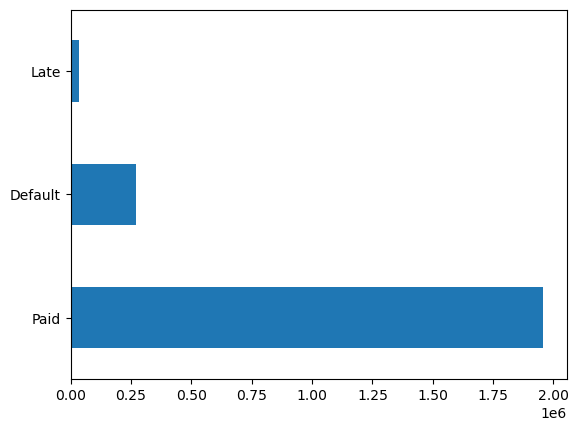

In [213]:
accepted_cleaner['loan_status'].value_counts().plot(kind='barh')
plt.show()

In [214]:
accepted_cleaner['loan_status'].value_counts()

Paid       1957056
Default     269360
Late         34252
Name: loan_status, dtype: int64

In [215]:
(269360 + 34252) / 1957056

0.1551371038948298

## Split into Categorical and Numerical

In [216]:
accepted_cleaner.dtypes.value_counts()

float64    67
object     20
dtype: int64

In [217]:
categorical_df = accepted_cleaner.select_dtypes('object').copy()
categorical_df.head()

,id,term,grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,36 months,C,leadman,10+ years,MORTGAGE,Not Verified,Dec-2015,Paid,n,debt_consolidation,PA,Aug-2003,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,68355089,36 months,C,Engineer,10+ years,MORTGAGE,Not Verified,Dec-2015,Paid,n,small_business,SD,Dec-1999,w,Jun-2016,Mar-2019,Individual,N,Cash,N
2,68341763,60 months,B,truck driver,10+ years,MORTGAGE,Not Verified,Dec-2015,Paid,n,home_improvement,IL,Aug-2000,w,Jun-2017,Mar-2019,Joint App,N,Cash,N
3,66310712,60 months,C,Information Systems Officer,10+ years,MORTGAGE,Source Verified,Dec-2015,Paid,n,debt_consolidation,NJ,Sep-2008,w,Feb-2019,Mar-2019,Individual,N,Cash,N
4,68476807,60 months,F,Contract Specialist,3 years,MORTGAGE,Source Verified,Dec-2015,Paid,n,major_purchase,PA,Jun-1998,w,Jul-2016,Mar-2018,Individual,N,Cash,N


In [218]:
numerical_df = accepted_cleaner.select_dtypes('float64').copy()
numerical_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,3600.0,3600.0,3600.0,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,122.67,564.0,560.0,0.0,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0
1,24700.0,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,926.35,699.0,695.0,0.0,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0
2,20000.0,20000.0,20000.0,10.78,432.66,63000.0,10.78,0.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,15813.30,704.0,700.0,0.0,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0
3,35000.0,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,829.90,679.0,675.0,0.0,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0
4,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,10128.96,704.0,700.0,0.0,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0


## Chi-Square between columns and `loan status`

In [219]:
target_variable = 'loan_status'

for column in categorical_df.columns:
    if column != target_variable:
        
        contingency_table = pd.crosstab(categorical_df[column], categorical_df[target_variable])

        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        print(f"Chi-square test for {column} vs {target_variable}: chi2={chi2}, p-value={p_value}")

Chi-square test for id vs loan_status: chi2=4521335.999999995, p-value=0.4996462223469619
Chi-square test for term vs loan_status: chi2=19621.43675615806, p-value=0.0
Chi-square test for grade vs loan_status: chi2=123285.16343819369, p-value=0.0
Chi-square test for emp_title vs loan_status: chi2=1045797.829074492, p-value=8.039433294667707e-46
Chi-square test for emp_length vs loan_status: chi2=846.9078842497792, p-value=1.5384714702735792e-166
Chi-square test for home_ownership vs loan_status: chi2=6482.317824289708, p-value=0.0
Chi-square test for verification_status vs loan_status: chi2=21059.676585594236, p-value=0.0
Chi-square test for issue_d vs loan_status: chi2=103852.76345359121, p-value=0.0
Chi-square test for pymnt_plan vs loan_status: chi2=39916.56750948081, p-value=0.0
Chi-square test for purpose vs loan_status: chi2=6219.525524724402, p-value=0.0
Chi-square test for addr_state vs loan_status: chi2=3826.9444593001026, p-value=0.0
Chi-square test for earliest_cr_line vs loa

Only id has a high p-value but since its insignificant we can drop it from out data.

In [220]:
categorical_df = categorical_df.drop(columns='id')
accepted_cleaner = accepted_cleaner.drop(columns='id')

In [221]:
accepted_cleaner.shape

(2260701, 86)

In [222]:
categorical_df.head() 

,term,grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,36 months,C,leadman,10+ years,MORTGAGE,Not Verified,Dec-2015,Paid,n,debt_consolidation,PA,Aug-2003,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,36 months,C,Engineer,10+ years,MORTGAGE,Not Verified,Dec-2015,Paid,n,small_business,SD,Dec-1999,w,Jun-2016,Mar-2019,Individual,N,Cash,N
2,60 months,B,truck driver,10+ years,MORTGAGE,Not Verified,Dec-2015,Paid,n,home_improvement,IL,Aug-2000,w,Jun-2017,Mar-2019,Joint App,N,Cash,N
3,60 months,C,Information Systems Officer,10+ years,MORTGAGE,Source Verified,Dec-2015,Paid,n,debt_consolidation,NJ,Sep-2008,w,Feb-2019,Mar-2019,Individual,N,Cash,N
4,60 months,F,Contract Specialist,3 years,MORTGAGE,Source Verified,Dec-2015,Paid,n,major_purchase,PA,Jun-1998,w,Jul-2016,Mar-2018,Individual,N,Cash,N


## Remainder of Null Values 

In [223]:
print(accepted_cleaner.isna().sum().sum())

2710572


In [224]:
# find all rows with a null value
null_rows = accepted_cleaner[accepted_cleaner.isnull().any(axis=1)]
null_rows

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
19,8650.0,8650.0,8650.0,36 months,19.89,320.99,E,Program Coordinator,8 years,RENT,55000.0,Verified,Dec-2015,Paid,n,debt_consolidation,IN,25.49,0.0,Mar-2005,675.0,679.0,4.0,18.0,1.0,9568.0,46.0,19.0,w,0.00,0.00,9190.490000,9190.49,8650.00,540.49,0.0,0.0,0.0,May-2016,8251.42,Jun-2016,639.0,635.0,0.0,Individual,0.0,0.0,18926.0,20750.0,17.0,1051.0,1375.0,45.0,0.0,0.0,129.0,95.0,0.0,0.0,0.0,8.0,0.0,2.0,17.0,2.0,2.0,2.0,17.0,17.0,13.0,18.0,NaN,0.0,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0,N,Cash,N
55,24000.0,24000.0,24000.0,60 months,9.80,507.58,B,NaN,NaN,OWN,77900.0,Not Verified,Dec-2015,Paid,n,home_improvement,TN,10.24,0.0,Oct-1982,740.0,744.0,1.0,9.0,0.0,3454.0,10.3,21.0,w,10182.57,10182.57,19255.370000,19255.37,13817.43,5437.94,0.0,0.0,0.0,Feb-2019,507.58,Mar-2019,814.0,810.0,0.0,Individual,0.0,0.0,127412.0,33600.0,1.0,14157.0,27172.0,10.9,0.0,0.0,139.0,398.0,22.0,22.0,2.0,22.0,1.0,2.0,3.0,4.0,6.0,6.0,7.0,13.0,3.0,9.0,0.0,0.0,0.0,0.0,95.2,0.0,0.0,0.0,202351.0,4910.0,30500.0,33631.0,N,Cash,N
75,1500.0,1500.0,1500.0,36 months,6.49,45.97,A,NaN,NaN,MORTGAGE,45000.0,Not Verified,Dec-2015,Paid,n,vacation,HI,16.11,0.0,Dec-1987,745.0,749.0,0.0,12.0,0.0,3717.0,21.2,37.0,w,0.00,0.00,1598.983365,1598.98,1500.00,98.98,0.0,0.0,0.0,Apr-2017,956.75,Mar-2019,739.0,735.0,0.0,Individual,0.0,0.0,158643.0,17500.0,8.0,15864.0,8818.0,27.7,0.0,0.0,123.0,336.0,6.0,3.0,4.0,6.0,0.0,1.0,3.0,4.0,15.0,8.0,9.0,25.0,3.0,12.0,0.0,0.0,0.0,4.0,97.2,0.0,0.0,0.0,179105.0,18400.0,12200.0,18050.0,N,Cash,N
86,15000.0,15000.0,15000.0,36 months,10.78,489.52,B,Coaching General Manager,1 year,RENT,40000.0,Verified,Dec-2015,Paid,n,credit_card,TX,10.17,0.0,Oct-2006,670.0,674.0,0.0,7.0,0.0,12272.0,75.3,9.0,w,0.00,0.00,17653.902092,17653.90,15000.00,2653.90,0.0,0.0,0.0,Nov-2018,1464.61,Dec-2018,724.0,720.0,0.0,Individual,0.0,0.0,12272.0,16300.0,2.0,2045.0,347.0,96.6,0.0,0.0,NaN,110.0,3.0,3.0,0.0,3.0,0.0,4.0,6.0,4.0,4.0,0.0,7.0,9.0,6.0,7.0,0.0,0.0,0.0,2.0,100.0,100.0,0.0,0.0,16300.0,12272.0,10300.0,0.0,N,Cash,N
93,15000.0,15000.0,15000.0,36 months,5.32,451.73,A,NaN,NaN,RENT,80000.0,Not Verified,Dec-2015,Paid,n,debt_consolidation,VA,20.18,0.0,Apr-1993,775.0,779.0,1.0,30.0,0.0,41593.0,21.4,47.0,w,0.00,0.00,16241.275489,16241.28,15000.00,1241.28,0.0,0.0,0.0,Sep-2018,2244.30,Sep-2018,799.0,795.0,0.0,Individual,0.0,0.0,330562.0,194800.0,6.0,13773.0,114609.0,4.2,0.0,0.0,141.0,272.0,2.0,2.0,2.0,2.0,0.0,7.0,12.0,12.0,19.0,6.0,28.0,39.0,12.0,30.0,0.0,0.0,0.0,2.0,97.9,0.0,0.0,0.0,537200.0,97129.0,119600.0,94400.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

### Rows with all Null 

Some rows have only null. Find how many and drop.

In [225]:
accepted_cleaner.isnull().all(axis=1).sum()

33

In [226]:
accepted_cleaner = accepted_cleaner.dropna(how='all')

In [227]:
accepted_cleaner.isnull().all(axis=1).sum()

0

In [228]:
null_columns=accepted_cleaner.columns[accepted_cleaner.isnull().any()]
null_columns

Index(['emp_title', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'last_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit'], dtype='object')

In [229]:
accepted_cleaner.isnull().sum(axis = 0)   

loan_amnt                          0
funded_amnt                        0
funded_amnt_inv                    0
term                               0
int_rate                           0
installment                        0
grade                              0
emp_title                     166969
emp_length                    146907
home_ownership                     0
annual_inc                         4
verification_status                0
issue_d                            0
loan_status                        0
pymnt_plan                         0
purpose                            0
addr_state                         0
dti                             1711
delinq_2yrs                       29
earliest_cr_line                  29
fico_range_low                     0
fico_range_high                    0
inq_last_6mths                    30
open_acc                          29
pub_rec                           29
revol_bal                          0
revol_util                      1802
t

### Rows with 70276 null values

There are 16 columns that have 70276 null values so lets look at a few of these columns and see if the indicies are the same.

In [230]:
col1 = accepted_cleaner[accepted_cleaner['tot_coll_amt'].isnull()].index.tolist()
col2 = accepted_cleaner[accepted_cleaner['tot_cur_bal'].isnull()].index.tolist()
col3 = accepted_cleaner[accepted_cleaner['total_rev_hi_lim'].isnull()].index.tolist()
col4 = accepted_cleaner[accepted_cleaner['mo_sin_rcnt_tl'].isnull()].index.tolist()
col5 = accepted_cleaner[accepted_cleaner['num_accts_ever_120_pd'].isnull()].index.tolist()
col6 = accepted_cleaner[accepted_cleaner['num_actv_bc_tl'].isnull()].index.tolist()
col7 = accepted_cleaner[accepted_cleaner['num_actv_rev_tl'].isnull()].index.tolist()
col1==col2==col3==col4==col5==col6==col7

True

We are going to drop all of these rows.

In [231]:
accepted_cleaner = accepted_cleaner.drop(index=accepted_cleaner[accepted_cleaner['tot_coll_amt'].isnull()].index.tolist(), columns='tot_coll_amt')

In [232]:
accepted_cleaner.isnull().sum(axis = 0)

loan_amnt                          0
funded_amnt                        0
funded_amnt_inv                    0
term                               0
int_rate                           0
installment                        0
grade                              0
emp_title                     162631
emp_length                    144846
home_ownership                     0
annual_inc                         0
verification_status                0
issue_d                            0
loan_status                        0
pymnt_plan                         0
purpose                            0
addr_state                         0
dti                             1711
delinq_2yrs                        0
earliest_cr_line                   0
fico_range_low                     0
fico_range_high                    0
inq_last_6mths                     1
open_acc                           0
pub_rec                            0
revol_bal                          0
revol_util                      1681
t

This ended up getting rid of Null values in a lot of our columns. Now look at the rest of the columns:

### Employment Title and Length

In [233]:
accepted_cleaner[accepted_cleaner['emp_title'].isna()]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
55,24000.0,24000.0,24000.0,60 months,9.80,507.58,B,NaN,NaN,OWN,77900.0,Not Verified,Dec-2015,Paid,n,home_improvement,TN,10.24,0.0,Oct-1982,740.0,744.0,1.0,9.0,0.0,3454.0,10.3,21.0,w,10182.57,10182.57,19255.370000,19255.37,13817.43,5437.94,0.0,0.0,0.0,Feb-2019,507.58,Mar-2019,814.0,810.0,0.0,Individual,0.0,127412.0,33600.0,1.0,14157.0,27172.0,10.9,0.0,0.0,139.0,398.0,22.0,22.0,2.0,22.0,1.0,2.0,3.0,4.0,6.0,6.0,7.0,13.0,3.0,9.0,0.0,0.0,0.0,0.0,95.2,0.0,0.0,0.0,202351.0,4910.0,30500.0,33631.0,N,Cash,N
75,1500.0,1500.0,1500.0,36 months,6.49,45.97,A,NaN,NaN,MORTGAGE,45000.0,Not Verified,Dec-2015,Paid,n,vacation,HI,16.11,0.0,Dec-1987,745.0,749.0,0.0,12.0,0.0,3717.0,21.2,37.0,w,0.00,0.00,1598.983365,1598.98,1500.00,98.98,0.0,0.0,0.0,Apr-2017,956.75,Mar-2019,739.0,735.0,0.0,Individual,0.0,158643.0,17500.0,8.0,15864.0,8818.0,27.7,0.0,0.0,123.0,336.0,6.0,3.0,4.0,6.0,0.0,1.0,3.0,4.0,15.0,8.0,9.0,25.0,3.0,12.0,0.0,0.0,0.0,4.0,97.2,0.0,0.0,0.0,179105.0,18400.0,12200.0,18050.0,N,Cash,N
93,15000.0,15000.0,15000.0,36 months,5.32,451.73,A,NaN,NaN,RENT,80000.0,Not Verified,Dec-2015,Paid,n,debt_consolidation,VA,20.18,0.0,Apr-1993,775.0,779.0,1.0,30.0,0.0,41593.0,21.4,47.0,w,0.00,0.00,16241.275489,16241.28,15000.00,1241.28,0.0,0.0,0.0,Sep-2018,2244.30,Sep-2018,799.0,795.0,0.0,Individual,0.0,330562.0,194800.0,6.0,13773.0,114609.0,4.2,0.0,0.0,141.0,272.0,2.0,2.0,2.0,2.0,0.0,7.0,12.0,12.0,19.0,6.0,28.0,39.0,12.0,30.0,0.0,0.0,0.0,2.0,97.9,0.0,0.0,0.0,537200.0,97129.0,119600.0,94400.0,N,Cash,N
139,25000.0,25000.0,25000.0,36 months,7.49,777.55,A,NaN,NaN,MORTGAGE,132000.0,Not Verified,Dec-2015,Paid,n,debt_consolidation,MI,13.83,0.0,Aug-1974,745.0,749.0,1.0,14.0,0.0,33231.0,48.0,32.0,w,0.00,0.00,27965.413567,27965.41,25000.00,2965.41,0.0,0.0,0.0,Jan-2019,777.17,Dec-2018,734.0,730.0,0.0,Individual,0.0,78666.0,69200.0,6.0,5619.0,22487.0,53.2,0.0,0.0,77.0,496.0,19.0,1.0,3.0,19.0,0.0,1.0,3.0,4.0,10.0,11.0,9.0,17.0,4.0,14.0,0.0,0.0,0.0,3.0,100.0,50.0,0.0,0.0,137788.0,50636.0,48100.0,30190.0,N,Cash,N
141,2500.0,2500.0,2500.0,36 months,11.48,82.42,B,NaN,NaN,RENT,16488.0,Not Verified,Dec-2015,Paid,n,debt_consolidation,CT,38.06,0.0,Nov-2005,770.0,774.0,1.0,12.0,0.0,2469.0,8.2,18.0,w,0.00,0.00,2962.969249,2962.97,2500.00,462.97,0.0,0.0,0.0,Jan-2019,82.26,Mar-2019,684.0,680.0,0.0,Individual,0.0,20449.0,30100.0,5.0,2045.0,18432.0,11.4,0.0,0.0,121.0,104.0,18.0,8.0,0.0,20.0,0.0,1.0,2.0,4.0,6.0,5.0,8.0,11.0,2.0,12.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,51341.0,20449.0,20800.0,21241.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Many rows have null in both `emp_title` and `emp_length` so lets find those indicies and drop them.

In [234]:
employment = accepted_cleaner[(accepted_cleaner['emp_title'].isnull())&(accepted_cleaner['emp_length'].isnull())].index.tolist()
len(employment)

144127

In [235]:
accepted_cleaner = accepted_cleaner.drop(employment)

There might also be many rows with null values in both `bc_open_to_buy` and `bc_util` as they are both referring to bankcards.

### Columns that refer to Bankcard accounts 

In [236]:
bankcards = accepted_cleaner[(accepted_cleaner['bc_open_to_buy'].isnull())&(accepted_cleaner['bc_util'].isnull())].index.tolist()
len(bankcards)

22049

In [237]:
accepted_cleaner = accepted_cleaner.drop(bankcards)

In [238]:
accepted_cleaner.isnull().sum(axis = 0)

loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
emp_title                     18303
emp_length                      710
home_ownership                    0
annual_inc                        0
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
purpose                           0
addr_state                        0
dti                             112
delinq_2yrs                       0
earliest_cr_line                  0
fico_range_low                    0
fico_range_high                   0
inq_last_6mths                    1
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                      220
total_acc                   

Look at `mo_sin_old_il_acct`

### Months since oldest installment account

In [243]:
accepted_cleaner['mo_sin_old_il_acct'].nunique()

554

Months since oldest installment accounts is not a column that we can fill in null values as it would distrupt the rest of the columns so drop rows.

In [244]:
installment = accepted_cleaner[(accepted_cleaner['mo_sin_old_il_acct'].isnull())].index.tolist()
len(installment)

57604

In [246]:
accepted_cleaner = accepted_cleaner.drop(installment)

### Number of accounts ever 120 days past due

In [247]:
accepted_cleaner['num_tl_120dpd_2m'].nunique()

7

In [248]:
accepted_cleaner['num_tl_120dpd_2m'].value_counts()

0.0    1889456
1.0       1115
2.0         43
3.0          3
6.0          1
7.0          1
4.0          1
Name: num_tl_120dpd_2m, dtype: int64

There are very few entries that have 1 or more accounts ever past 120 days, so to keep the rest of the rows, we are going to fill in 0 for the null values.

In [249]:
accepted_cleaner['num_tl_120dpd_2m'] = accepted_cleaner['num_tl_120dpd_2m'].fillna(0)

In [250]:
accepted_cleaner.isnull().sum(axis = 0)

loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
emp_title                     17110
emp_length                      665
home_ownership                    0
annual_inc                        0
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
purpose                           0
addr_state                        0
dti                             102
delinq_2yrs                       0
earliest_cr_line                  0
fico_range_low                    0
fico_range_high                   0
inq_last_6mths                    1
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                      210
total_acc                   

### Last Month Payment was Received

In [252]:
accepted_cleaner['last_pymnt_d'].nunique()

79

In [253]:
accepted_cleaner['last_pymnt_d'].value_counts()

Mar-2019    756632
Feb-2019     87032
Aug-2018     35357
Mar-2018     34634
Jan-2019     34318
Oct-2018     33033
Jul-2018     32791
Jun-2018     31576
Nov-2018     31414
May-2018     30101
Jan-2018     29966
Mar-2017     29739
Dec-2018     29271
Aug-2017     28923
Oct-2017     28906
Apr-2018     28721
Nov-2017     28178
Sep-2018     28050
Feb-2018     28047
Jul-2017     27327
Jun-2017     26946
May-2017     25927
Sep-2017     24201
Dec-2017     24008
Apr-2017     23325
Jan-2017     22634
Feb-2017     22004
Dec-2016     21523
Oct-2016     20729
Nov-2016     20490
Aug-2016     20063
Sep-2016     20040
Jul-2016     19584
Mar-2016     18620
Jun-2016     18304
May-2016     16295
Apr-2016     15671
Feb-2016     15553
Dec-2015     14084
Oct-2015     14080
Jan-2016     13797
Sep-2015     12162
Nov-2015     11979
Jul-2015     11702
Aug-2015     10397
Jun-2015      9604
May-2015      8950
Apr-2015      8783
Mar-2015      8624
Feb-2015      6847
Jan-2015      6591
Oct-2014      5762
Dec-2014    

In [254]:
print(accepted_cleaner.isna().sum().sum())

21653


## Numerical Columns 

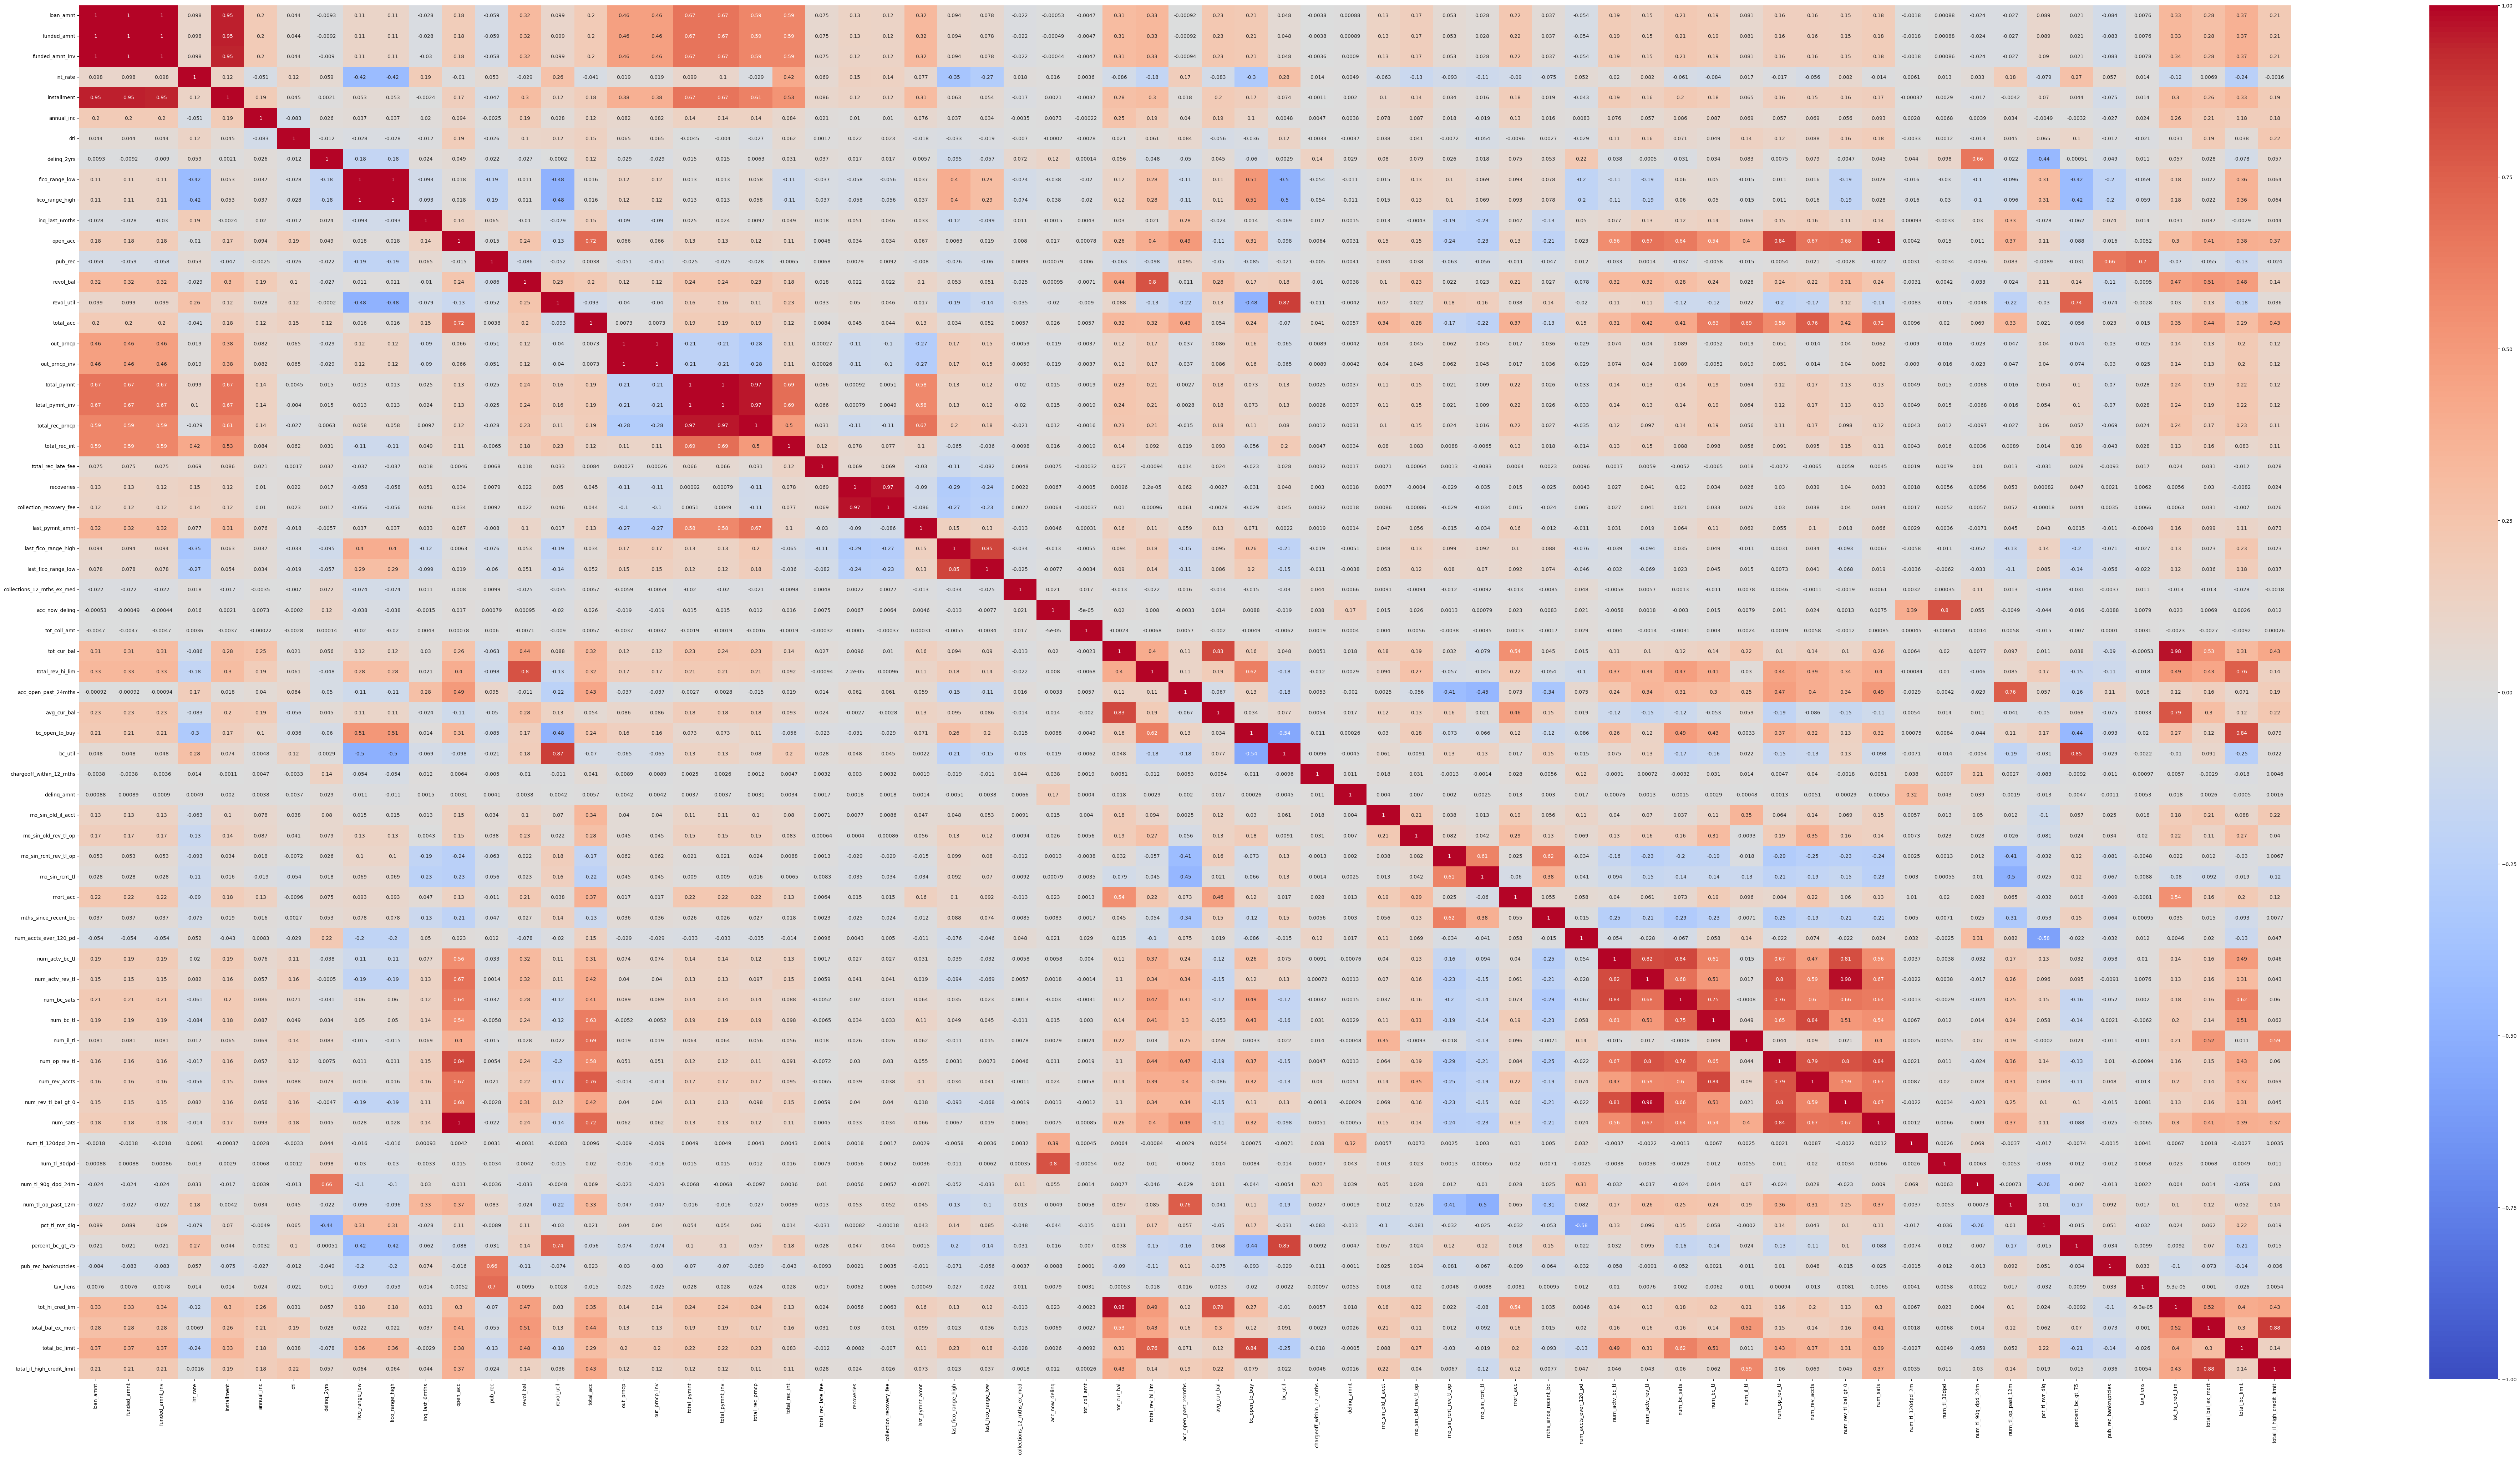

In [43]:
fig, ax = plt.subplots(figsize=(100,50))
sns.heatmap(numerical_df.corr(), cmap='coolwarm', annot = True, vmin=-1, vmax=1, ax=ax)
plt.show()

In [ ]:
for i in range(numerical_df.shape[1] - 1):
    current_col = numerical_df.columns[i]
    next_col = numerical_df.columns[i+1]
    
    # conduct Pearson correlation test
    corr, p_value = pearsonr(numerical_df[current_col], numerical_df[next_col])
    print(f'Columns: {current_col} - {next_col}\t Correlation: {corr:.3f}\t p-value: {p_value:.3f}')